<a href="https://colab.research.google.com/github/jnsbrdbr/new_thesiis/blob/main/9.3_Gaussian_Svm_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
with pd.HDFStore('/content/drive/MyDrive/1000/part2_result',  mode='r') as newstore:
    result = newstore.select('result')

In [4]:
print(result)

             0         1         2             3             4         5  \
0    -1.468407 -3.098769 -0.040978  6.204485e-14  2.991009e-14  0.078341   
1    -1.468407 -3.098769 -0.040978 -1.233238e-14  2.951113e-14  0.078341   
2    -1.468407 -3.098769 -0.040978 -7.431131e-14  3.860443e-14  0.078341   
3    -1.468407 -3.098769 -0.040978  1.650248e-14 -1.360452e-14  0.078341   
4    -1.468407 -3.098769 -0.040978  8.579407e-15  2.671601e-14  0.078341   
...        ...       ...       ...           ...           ...       ...   
1315 -1.468407 -3.098769 -0.040978  1.269764e-14  2.287279e-14  0.078341   
1316 -1.468407 -3.098769 -0.040978  1.269764e-14  2.287279e-14  0.078341   
1317 -1.468407 -3.098769 -0.040978  1.269764e-14  2.287279e-14  0.078341   
1318 -1.468407 -3.098769 -0.040978  1.269764e-14  2.287279e-14  0.078341   
1319 -1.468407 -3.098769 -0.040978  1.269764e-14  2.287279e-14  0.078341   

            6         7         8         9  ...         1         2  \
0     2.36865 -

In [5]:
import copy
result_nonlabel=copy.deepcopy(result)
del result_nonlabel['label']
X=result_nonlabel
y=result.label

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    shuffle=True)

In [7]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import svm

k=svm.SVC(kernel="rbf", gamma='scale', C=1000, probability=True)#gamma=0.0001, C=10#gamma=0.1, C=10,
gpc = k.fit(x_train, y_train)

In [8]:
predictions = gpc.predict(x_test)
score = gpc.score(x_test, y_test)
print(score)

0.9678030303030303


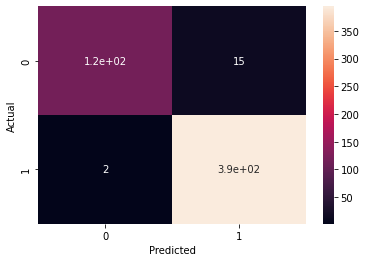

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics



confusion_matrix = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)


In [10]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

True Positives: 394
False Positives: 15
True Negatives: 117
False Negatives: 2


In [11]:
print('Accuracy: ',metrics.accuracy_score(y_test, predictions))

Accuracy:  0.9678030303030303


In [12]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


cv = KFold(n_splits=10, shuffle=True)# x_train, y_train, random_state=42
scores = cross_val_score(k,X, y, scoring='accuracy', cv=cv,n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.966 (0.014)


In [13]:
#recall

from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_val_predict


cv = KFold(n_splits=10, shuffle=True)#, random_state=42
scores_recall = cross_val_score(k,X, y, scoring='recall', cv=cv,n_jobs=-1)

print('scores_recall: %.3f (%.3f)' % (mean(scores_recall), std(scores_recall)))

scores_recall: 0.991 (0.009)


In [14]:
#precision

from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


cv = KFold(n_splits=10, shuffle=True)#, random_state=42
scores_precision = cross_val_score(k, X, y, scoring='precision', cv=cv,n_jobs=-1)

print('scores_precision: %.3f (%.3f)' % (mean(scores_precision), std(scores_precision)))

scores_precision: 0.964 (0.031)


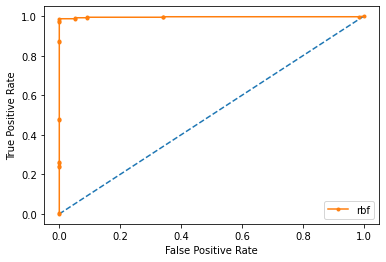


 Logistic ROC AUC 0.996


In [15]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


k=svm.SVC(kernel="rbf", gamma='scale', C=1000, probability=True)#gamma=0.0001, C=10,gamma=0.1, C=10
k.fit(x_train, y_train)
yhat = k.predict_proba(x_test)
pos_probs = yhat[:, 1]
pyplot.plot([0, 1], [0, 1], linestyle='--')
fpr, tpr, _ = roc_curve(y_test, pos_probs)
pyplot.plot(fpr, tpr, marker='.', label='rbf')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

roc_auc = roc_auc_score(y_test, pos_probs)
print('\n','Logistic ROC AUC %.3f' % roc_auc)

In [16]:
#Importing required libraries
from sklearn.model_selection import KFold 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
 
#data = load_breast_cancer(as_frame = True)
#df = result.frame
#X = result.iloc[:,:-1]
#y = result.iloc[:,-1]
 
#Implementing cross validation
 
#X = X.sample(frac = 1)
#y= y.sample(frac = 1)
kf = KFold(n_splits=10)#, random_state=None
model = svm.SVC(kernel="rbf",gamma='scale', C=1000)#gamma=0.1, C=10
 
acc_score = list()
res_tpr = list()
res_fpr = list()
for train_index , test_index in kf.split(X):
    #X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    #y_train , y_test = y[train_index] , y[test_index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, pred_values, labels=[0, 1]).ravel()
    print(f'True Positives: {tp}')
    print(f'False Positives: {fp}')
    print(f'True Negatives: {tn}')
    print(f'False Negatives: {fn}')
    tpr=(np.divide(tp,(tp+fn)))
    fpr=(np.divide(fp,(fp+tn)))
    if tp==0:
      tpr=0
    if fp==0:
      fpr=0

    print('fpr=%.3f' % (mean(fpr)))#tpr=%.4f : mean(tpr), 
    print('x')
    res_tpr.append(mean(tpr))
    res_fpr.append(mean(fpr))
    print('---------------------')

    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = np.sum(acc_score)/10
total_tpr=np.sum(res_tpr)/10
total_fpr=np.sum(res_fpr)/10
print('\n\n','total_fpr=%.3f' % (total_fpr))# total_tpr=%.4f :total_tpr,
print('\n\n','total_tpr=%.3f' % (total_tpr))

True Positives: 388
False Positives: 20
True Negatives: 116
False Negatives: 4
fpr=0.147
x
---------------------
True Positives: 402
False Positives: 17
True Negatives: 107
False Negatives: 2
fpr=0.137
x
---------------------
True Positives: 394
False Positives: 15
True Negatives: 115
False Negatives: 4
fpr=0.115
x
---------------------
True Positives: 379
False Positives: 21
True Negatives: 124
False Negatives: 4
fpr=0.145
x
---------------------
True Positives: 397
False Positives: 9
True Negatives: 117
False Negatives: 5
fpr=0.071
x
---------------------
True Positives: 389
False Positives: 24
True Negatives: 113
False Negatives: 2
fpr=0.175
x
---------------------
True Positives: 384
False Positives: 14
True Negatives: 124
False Negatives: 6
fpr=0.101
x
---------------------
True Positives: 392
False Positives: 8
True Negatives: 126
False Negatives: 2
fpr=0.060
x
---------------------
True Positives: 388
False Positives: 29
True Negatives: 107
False Negatives: 4
fpr=0.213
x
-------